In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinvh

In [19]:
def as_matrix(x):
    return x.reshape([x.shape[0], -1])

def grid_coords(a, b=None, t=None):
    x, y = np.meshgrid(np.arange(a), np.arange(a) if b is None else b)
    xy = []
    for xi, yi in zip(x.flatten(), y.flatten()):
        xy.append([xi, yi])
    if t:
        return t(np.stack(xy, axis=0))
    return np.stack(xy, axis=0)

# RBF kernel

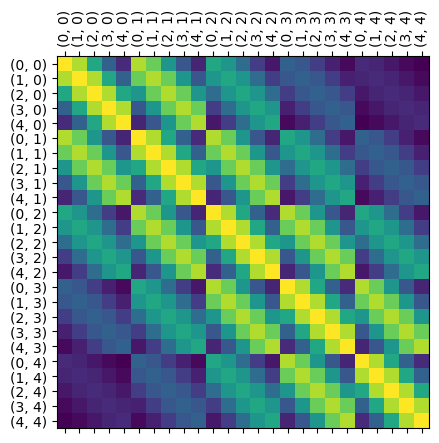

In [4]:
def rbf(x1, x2, lscale=1.0, obsvar=1.0):
    # Convert to column vectors
    x1 = as_matrix(x1)
    x2 = as_matrix(x2)
    
    # Make sure inputs have the same number of dimensions
    assert x1.shape[1] == x2.shape[1], f'x1 and x2 must the same number of dimensions. You have {x1.shape[1]} and {x2.shape[1]}'
    if np.size(lscale) == 1:
        lscale = np.full(x1.shape[1], lscale)
    else:
        assert lscale.size == x1.shape[1], f'lscale was passed as an array; it must have the same size as the number of dimensions in x1 and x2'

    # Get dimensions
    n1, n2 = x1.shape[0], x2.shape[0]
    d = x1.shape[1]
    
    # Initialize the covariance matrix
    K = np.zeros(n1*n2).reshape([n1, -1])

    # Compute scaled squared distance between each pair of points in x1 and x2
    # Note: scaling factor can be different for different dimensions
    for cx1, cx2, l in zip(x1.T, x2.T, lscale):
        K += (np.subtract.outer(cx1, cx2)/l)**2
    
    return obsvar * np.exp(-0.5 * K)

        
coords = grid_coords(5)
cov = rbf(coords, coords, 2, 1)
plt.matshow(cov)

ax = plt.gca()

ticks = np.arange(coords.shape[0])
ticklabels = [f'({x}, {y})' for (x, y) in coords]
_ = plt.xticks(ticks)
_ = plt.yticks(ticks)
_ = plt.gca().set_xticklabels(ticklabels, rotation=90)
_ = plt.gca().set_yticklabels(ticklabels)

# Gaussian Process Regression
We follow the terminology from Rasmussen & Williams. The `train_set` should be a dictionary with two items. The key `'X'` should point to a design matrix $n \times d$, where $n$ is the number of observations, and $d$ is the number of features. Thus, *rows* of `train_set['X']` are input feature vectors (unlike in R&W) The key `'y'` should point to a column vector of observations where the $i$-th row-element corresponds to the observation associated with the $i$-th row in `X`.

In [301]:
def gpr(test_set, train_set, kernel, kernel_kwargs={}, noise=0.0):
    # The notation for indexing covariance matrix components is inspired by P. Roelant's blog:
    # https://peterroelants.github.io/posts/gaussian-process-tutorial/#Sidenotes
    default_noise = 0.0001
    test_set = as_matrix(test_set) # Make sure `test_set` is a matrix

    X, y = as_matrix(train_set['X']), as_matrix(train_set['y']) # extract design matrix and observation vector from `train_set`
    n, d = X.shape # get number of features (=2 in the paper) and number of observations
    K11 = kernel(X, X, **kernel_kwargs) # kernel of observations
    K11 += np.identity(n) * default_noise # add default noise
    K11 += np.identity(n) * noise # add variable noise

    # Invert the covariance matrix
    if np.all(np.linalg.eigvals(K11) > 0):
        K11_inv = pinvh(K11)
    else:
        raise np.linalg.LinAlgError

    # Estimate mean and variance for `test_set` datapoints using RBF generalization
    m, v = [], []
    for loc in test_set:
        X_new = loc.reshape([1, -1])
        K12 = kernel(X, X_new, **kernel_kwargs)
        K22 = kernel(X_new, X_new, **kernel_kwargs)
        K_mult = np.matmul(K12.T, K11_inv)
        m.append(np.squeeze(np.matmul(K_mult, y)))
        v.append(np.squeeze(K22 - np.matmul(K_mult, K12) + default_noise))

    preds = np.zeros([test_set.shape[0], test_set.shape[1] + 2])
    preds[:, 0:2] = test_set
    preds[:, 2] = np.stack(m, axis=0)
    preds[:, 3] = np.stack(v, axis=0)

    return preds

# Forgetfulness GPR

In [371]:
def forgetful_gpr(test_set, train_set, feature_weights, horizon, kernel, kernel_kwargs={}, neg_bias=1.0, default=0.0001):
    prior_mean = 0.0
    X, y = as_matrix(train_set['X']), as_matrix(train_set['y'])
    
    # Recency [0, 1]
    # Older observations are closer to 0 and recent observations are closer to 1
    time = np.arange(1, y.shape[0]+1)
    f_recency = (time.max() - time) / horizon
    
    # Surprise [0, 1]
    # Observations close to the mean are closer to 0 and extreme observations are closer to 1
    diff = y.squeeze() - prior_mean
    diff[diff < 0] = -diff[diff < 0] * neg_bias
    f_surprise = 1 - np.sqrt(diff)

    # Decay factor := linear combination of recency and surprise features of observations
    features = np.stack([f_recency, f_surprise], axis=1)
    weights = as_matrix(feature_weights)
    decay_factor = np.matmul(features, weights)
    
    # Scale default noise and combine with decay factor
    noise = default * np.exp(decay_factor)
    
    # Cap values for numerical stability
    noise[noise > 10**10] = 10**10

    return gpr(test_set, train_set, kernel, kernel_kwargs, noise=noise)

# 1D visualization

In [415]:
def plot_sim(ax, test_set, train_set, kernel, kernel_kwargs, horizon, feature_weights, neg_bias, default_noise, k, accent, xlabel='', title=''):
    trans = lambda x: x/2 + 0.5
    x_ = np.arange(k)
    inds = train_set['inds']

    predictions = forgetful_gpr(
        test_set = test_set,
        train_set = train_set,
        kernel = kernel,
        kernel_kwargs = kernel_kwargs,
        horizon = horizon,
        feature_weights = feature_weights,
        neg_bias = neg_bias,
        default = default_noise
    )

    # Ground truth
    ax.plot(x_, trans(y), ls='-', alpha=.4, color='k')
    ax.axhline(0.5, color=accent, ls='--')
    ax.axhline(0, color=accent, ls=':')
    ax.axhline(1, color=accent, ls=':')

    # Observations
    obsX = train_set['X'][:, -1]
    obsY = trans(train_set['y'])
    ax.plot(obsX, obsY, ls='', marker='o', markersize=5, alpha=.5, color='k', zorder=10)
    for i, (xi, yi) in enumerate(zip(obsX, obsY)):
        ax.annotate(f'{i+1}', xy=(xi, yi), xycoords='data', xytext=(xi-1, yi-.15), ha='right')

    # Predictions
    m = trans(predictions[:, -2])
    v = predictions[:, -1] / 4
    sd = np.sqrt(v)
    ax.plot(x_, m, color=accent, linewidth=2)
    ax.fill_between(x_, m+sd, m-sd, color=accent, alpha=.3)
    ax.errorbar(train_set['X'][:, -1], m[inds], sd[inds], color=accent, linestyle='', marker='o', markersize=5)

    # Plot params
    ax.set_xlim(0, 100)
    ax.set_ylim(-0.2, 1.2)

    # Plot labels
    ax.get_xaxis().set_ticklabels([])
    ax.set_xlabel(xlabel)

    ax.get_yaxis().set_ticks([0.0, 0.5, 1.0])
    ax.get_yaxis().set_ticklabels([r'$-1~\mathrm{s.d.}$', r'$\mu$', '$+1~\mathrm{s.d.}$'])
    ax.set_ylabel('Reward')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title, )

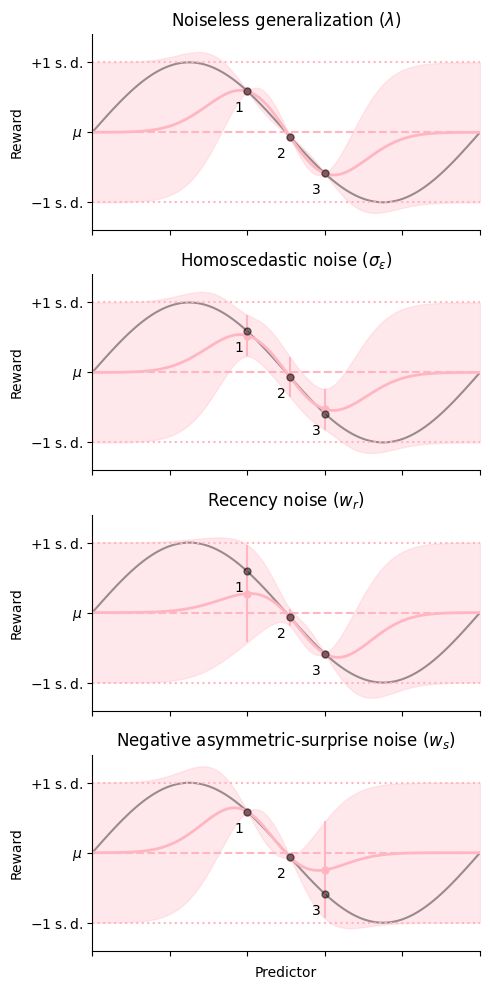

In [425]:
# Train and test data
k = 101
coords = grid_coords(k, 1, t=np.fliplr)

y = np.sin(np.linspace(0, 2*np.pi, k))
inds = np.array([40, 51, 60])
train_set = dict(
    inds = inds,
    X = np.stack(coords[inds], axis=0),
    y = y[inds]
)
test_set = coords[:]

# Params
titles = [
    r'Noiseless generalization ($\lambda$)',
    r'Homoscedastic noise ($\sigma_\epsilon$)',
    r'Recency noise ($w_r$)',
    r'Negative asymmetric-surprise noise ($w_s$)']
lscale = [10.0, 10.0, 10.0, 10.0]
default_noise = [0.0001, 0.1, 0.0001, 0.0001]
w_recency = [0.0, 0.0, 15.0, 0.0]
w_surprise = [0.0, 0.0, 0.0, -25.0]
feature_weights = np.stack([w_recency, w_surprise], axis=1)
neg_bias = [0.0, 0.0, 0.0, 5.0]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=[5, 10])
for i in range(4):
    plot_sim(
        ax = axes[i], 
        test_set = test_set,
        train_set = train_set,
        kernel = rbf,
        kernel_kwargs = dict(lscale=lscale[i]),
        horizon = 3,
        default_noise = default_noise[i],
        feature_weights = feature_weights[i],
        neg_bias = neg_bias[i],
        k = k,
        accent = 'lightpink',
        xlabel = 'Predictor' if i == 3 else '',
        title = titles[i]
    )
fig.tight_layout()
fig.savefig('params_example2.png')